# Sentiment Analysis Showdown: Custom LSTM vs. XLM-RoBERTa


In questo notebook confronteremo due approcci alla Sentiment Analysis usando il dataset `mental.csv` (colonne `statement` e `status`).


- Il dataset viene mescolato casualmente e suddiviso in: 81% train, 9% val (entrambi ricavati dal 90% del totale) e 10% test (usato **solo** nel confronto finale tra i modelli).


- Useremo lo stesso split per l'addestramento del modello LSTM e per il fine-tuning di XLM-RoBERTa (con LoRA).


- Includiamo una WordCloud sull'insieme di training per un'EDA veloce.

In [1]:
# Installazione dipendenze (se necessario)
!pip install transformers datasets wordcloud gensim seaborn torch scikit-learn pandas matplotlib accelerate peft


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
from peft import PeftModel, get_peft_model, LoraConfig, TaskType

# Configurazione Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1. Data Loading & EDA (Exploratory Data Analysis)

Dataset mental (bilanciato) size: 30305
Classi: {'depression': 0, 'light': 1, 'normal': 2, 'serious': 3}


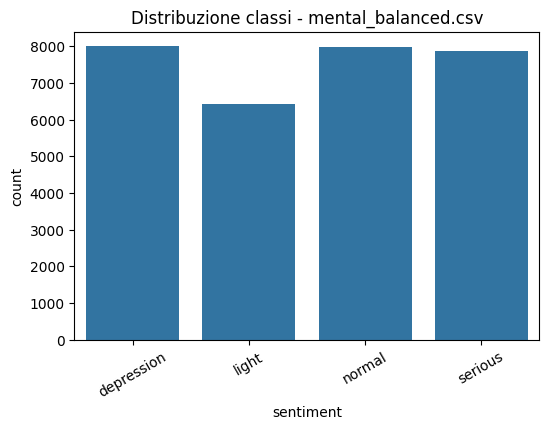

In [ ]:
# Caricamento dati: dataset mental bilanciato da 1_EDA_and_Baseline.ipynb
mental_path = '../data/processed/mental_balanced.csv'
df_mental = pd.read_csv(mental_path)

# Usa la colonna 'target' (già mappata e bilanciata) come sentiment, 'statement' come testo
df_mental = df_mental.rename(columns={'statement': 'review_text', 'target': 'sentiment'})

df_mental = df_mental[['review_text', 'sentiment']].dropna()
df_mental['review_text'] = df_mental['review_text'].astype(str)
df_mental['sentiment'] = df_mental['sentiment'].astype(str).str.lower().str.strip()


# Costruisci mapping etichette dinamico (ordinamento alfabetico)
labels_order = sorted(df_mental['sentiment'].unique())
sentiment_map = {label: idx for idx, label in enumerate(labels_order)}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
df_mental['label'] = df_mental['sentiment'].map(sentiment_map)


# Shuffle esplicito per tutto il dataset
df_mental = df_mental.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset mental (bilanciato) size: {len(df_mental)}")
print(f"Classi: {sentiment_map}")


# Distribuzione classi sul dataset completo
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df_mental, order=labels_order)
plt.title('Distribuzione classi - mental_balanced.csv')
plt.xticks(rotation=30)
plt.show()


In [ ]:
# Suddivisione: 81% train, 9% val (da 90% tot), 10% test (solo confronto finale)
test_size = 0.10
stratify_all = df_mental['label'] if df_mental['label'].nunique() > 1 else None

train_val_df, test_df = train_test_split(
    
    df_mental[['review_text', 'sentiment', 'label']],
    test_size=test_size,
    random_state=42,
    stratify=stratify_all
)


# Per ottenere 9% val sul totale: 0.10 / 0.90 ≈ 0.1111 della parte train_val
val_fraction = test_size / (1 - test_size)
stratify_train_val = train_val_df['label'] if train_val_df['label'].nunique() > 1 else None

train_df, val_df = train_test_split(

    train_val_df,
    test_size=val_fraction,
    random_state=42,
    stratify=stratify_train_val
)


print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")

In [ ]:
# Generazione WordCloud sul dataset di training (mental)
text_combined = " ".join(review for review in train_df.review_text)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud delle recensioni (train - mental.csv)")
plt.show()


## 2. Modello 1: Custom LSTM (con GloVe Twitter)

Replichiamo l'architettura del notebook precedente.

In [ ]:
# --- 2.1 Preprocessing specifico per LSTM ---
def clean_text_lstm(text):

    text = str(text).lower()

    # conserva emoji/emoticon rimuovendo solo url e caratteri di controllo
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[\r\n\t]+', ' ', text)
    text = re.sub(r'[^\w\s\U0001F300-\U0001FAFF]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Applica il preprocessing e tokenizza le partizioni (train/val/test dal mental split)
def add_tokens(df_in):
    df_out = df_in.copy()
    df_out['clean_text'] = df_out['review_text'].apply(clean_text_lstm)
    df_out['tokens'] = df_out['clean_text'].apply(lambda x: x.split())
    return df_out


train_df_lstm = add_tokens(train_df)
val_df_lstm = add_tokens(val_df)
test_df_lstm = add_tokens(test_df)


# Vocabolario costruito solo sul training set
all_words = [word for tokens in train_df_lstm['tokens'] for word in tokens]
word_counts = Counter(all_words)
min_freq = 2
vocab_list = sorted([k for k, v in word_counts.items() if v >= min_freq])
vocab = {word: i + 1 for i, word in enumerate(vocab_list)}
vocab_size = len(vocab) + 1


# Conversione Testo -> Indici
def text_to_indices(tokens, vocab, max_len=50):

    indices = [vocab[token] for token in tokens if token in vocab]

    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))

    else:
        indices = indices[:max_len]

    return indices

max_seq_len = 50

X_train_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in train_df_lstm['tokens']])
y_train_lstm = train_df_lstm['label'].values
X_val_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in val_df_lstm['tokens']])
y_val_lstm = val_df_lstm['label'].values
X_test_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in test_df_lstm['tokens']])
y_test_lstm = test_df_lstm['label'].values


# Dataset PyTorch
class ReviewDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)

    def __getitem__(self, idx): return self.X[idx], self.y[idx]


train_loader_lstm = DataLoader(ReviewDataset(X_train_lstm, y_train_lstm), batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(ReviewDataset(X_val_lstm, y_val_lstm), batch_size=32, shuffle=False)
test_loader_lstm = DataLoader(ReviewDataset(X_test_lstm, y_test_lstm), batch_size=32, shuffle=False)


# --- 2.2 Caricamento Embeddings GloVe ---
print("Caricamento GloVe Twitter... (potrebbe richiedere un po')")

try:
    glove_model = api.load("glove-twitter-100")
    embedding_dim = 100
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in vocab.items():

        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]

        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


except Exception as e:
    print(f"Errore caricamento GloVe: {e}. Uso embedding random.")
    embedding_dim = 100
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))


# --- 2.3 Definizione Modello ---
class SentimentLSTM(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(self.dropout(hidden))


# --- 2.4 Training Loop ---
model_lstm = SentimentLSTM(vocab_size, embedding_dim, 64, len(sentiment_map), embedding_matrix).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print("Training LSTM...")

lstm_val_history = []
epochs = 5

for epoch in range(epochs):

    model_lstm.train()

    for X_b, y_b in train_loader_lstm:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model_lstm(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        optimizer.step()


    # Validation
    model_lstm.eval()
    val_preds, val_targets = [], []

    with torch.no_grad():
        for X_b, y_b in val_loader_lstm:
            X_b = X_b.to(device)
            out = model_lstm(X_b)
            _, preds = torch.max(out, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y_b.numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    lstm_val_history.append(val_acc)
    print(f"LSTM Epoch {epoch + 1}: Val Accuracy {val_acc:.4f}")


# Test finale sul set di test (mental)
model_lstm.eval()
test_preds, test_targets = [], []

with torch.no_grad():
    for X_b, y_b in test_loader_lstm:
        X_b = X_b.to(device)
        out = model_lstm(X_b)
        _, preds = torch.max(out, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(y_b.numpy())

lstm_test_acc = accuracy_score(test_targets, test_preds)
lstm_test_f1 = f1_score(test_targets, test_preds, average='weighted')
lstm_cm = confusion_matrix(test_targets, test_preds)

print(f"LSTM Test Accuracy (mental test): {lstm_test_acc:.4f} | F1-weighted: {lstm_test_f1:.4f}")

# Salvataggio checkpoint LSTM in ../models (overwrite)
lstm_ckpt_dir = os.path.abspath(os.path.join('..', 'models'))
os.makedirs(lstm_ckpt_dir, exist_ok=True)

lstm_ckpt_path = os.path.join(lstm_ckpt_dir, 'lstm_sentiment.ckpt')

torch.save({
    'model_state_dict': model_lstm.state_dict(),
    'vocab': vocab,
    'sentiment_map': sentiment_map,
}, lstm_ckpt_path)

print(f"Checkpoint LSTM salvato in {lstm_ckpt_path}")

## 3. Modello 2: XLM-RoBERTa (Fine-Tuning)

Usiamo la libreria `transformers` per fine-tunare `xlm-roberta-base`.

In [ ]:
# --- 3.1 Preparazione Dati per Transformers (mental split) ---
from peft import LoraConfig, TaskType, get_peft_model

model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

X_train_raw, y_train_raw = train_df['review_text'], train_df['label']
X_val_raw, y_val_raw = val_df['review_text'], val_df['label']
X_test_raw, y_test_raw = test_df['review_text'], test_df['label']


def tokenize_function(texts):

    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)


# Creazione Dataset HuggingFace
train_dataset = HFDataset.from_dict({"text": X_train_raw.tolist(), "label": y_train_raw.tolist()})
val_dataset = HFDataset.from_dict({"text": X_val_raw.tolist(), "label": y_val_raw.tolist()})
test_dataset = HFDataset.from_dict({"text": X_test_raw.tolist(), "label": y_test_raw.tolist()})

train_tokenized = train_dataset.map(lambda batch: tokenize_function(batch['text']), batched=True)
val_tokenized = val_dataset.map(lambda batch: tokenize_function(batch['text']), batched=True)
test_tokenized = test_dataset.map(lambda batch: tokenize_function(batch['text']), batched=True)


# --- 3.2 Setup Trainer con LoRA ---
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(sentiment_map),
    id2label=reverse_sentiment_map,
    label2id=sentiment_map,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
).to(device)


peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    modules_to_save=["classifier"] # <--- Addestra e salva la testa di classificazione!
)

model_xlm = get_peft_model(base_model, peft_config)

def compute_metrics(eval_pred):
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {"accuracy": acc, "f1": f1}


xlm_ckpt_dir = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora_checkpoints'))
xlm_final_dir = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
os.makedirs(xlm_ckpt_dir, exist_ok=True)
os.makedirs(xlm_final_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=xlm_ckpt_dir,
    eval_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    learning_rate=2e-5,
    save_strategy="epoch",
    save_total_limit=1,
    overwrite_output_dir=True,
    use_cpu=not torch.cuda.is_available()
)


trainer = Trainer(
    model=model_xlm,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
)

# --- 3.3 Training ---
print("Training XLM-RoBERTa LoRA...")

trainer.train()

# Salva l'adapter LoRA (sovrascrive se esiste)
model_xlm.save_pretrained(xlm_final_dir)
tokenizer.save_pretrained(xlm_final_dir)

# Valutazione Finale sul test (mental)
print("Valutazione su mental test...")

test_pred = trainer.predict(test_tokenized)
test_logits = test_pred.predictions
test_labels = test_pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)

xlm_test_acc = accuracy_score(test_labels, test_preds)
xlm_test_f1 = f1_score(test_labels, test_preds, average='weighted')
xlm_cm = confusion_matrix(test_labels, test_preds)


print(f"XLM-RoBERTa (LoRA) Test Accuracy (mental test): {xlm_test_acc:.4f} | F1-weighted: {xlm_test_f1:.4f}")

## 4. Confronto Risultati

### Confusion matrix sul test set (mental)


Confrontiamo le confusion matrix complete per i due modelli sulle etichette reali del test di `mental.csv` (hold-out).

In [ ]:
models = ['Custom LSTM (GloVe)', 'XLM-RoBERTa']

accuracies = [lstm_test_acc, xlm_test_acc]
f1_scores = [lstm_test_f1, xlm_test_f1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(ax=axes[0], x=models, y=accuracies, palette='viridis')
axes[0].set_ylim(0, 1)
axes[0].set_title('Accuracy Modelli (mental test)')
axes[0].set_ylabel('Accuracy')

for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

sns.barplot(ax=axes[1], x=models, y=f1_scores, palette='magma')
axes[1].set_ylim(0, 1)
axes[1].set_title('F1-weighted Modelli (mental test)')
axes[1].set_ylabel('F1-weighted')

for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
labels_for_plot = labels_order
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_for_plot, yticklabels=labels_for_plot, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM (mental test)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
sns.heatmap(xlm_cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels_for_plot, yticklabels=labels_for_plot, ax=axes[1])
axes[1].set_title('Confusion Matrix - XLM-RoBERTa (mental test)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()

plt.show()

## 5. Confronto rapido: LSTM vs BERT pre-addestrato su 30 esempi (mental test)

In [ ]:
# Seleziona un campione casuale di 30 righe dal test set (mental)
n_eval = min(1000, len(test_df_lstm))
eval_df = test_df_lstm.sample(n=n_eval, random_state=42).copy()
y_true = eval_df['sentiment'].str.lower().tolist()


# --- Predizioni LSTM sul sottoinsieme ---
X_eval_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in eval_df['tokens']])

lstm_preds = []
model_lstm.eval()

with torch.no_grad():

    for i in range(0, len(X_eval_lstm), 32):
        batch = torch.tensor(X_eval_lstm[i:i+32], dtype=torch.long).to(device)
        logits = model_lstm(batch)
        _, preds = torch.max(logits, 1)

        lstm_preds.extend([reverse_sentiment_map[p.item()].lower() for p in preds.cpu()])




# --- Predizioni BERT già addestrato (LoRA se presente) ---
lora_path = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
base_name = 'xlm-roberta-base'

bert_tokenizer = AutoTokenizer.from_pretrained(lora_path if os.path.exists(lora_path) else base_name)

bert_base = AutoModelForSequenceClassification.from_pretrained(
    base_name,
    num_labels=len(sentiment_map),
    id2label=reverse_sentiment_map,
    label2id=sentiment_map,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
)

if os.path.exists(os.path.join(lora_path, 'adapter_config.json')):
    bert_model = PeftModel.from_pretrained(bert_base, lora_path)

else:
    bert_model = bert_base

bert_model.to(device)
bert_model.eval()

def predict_bert(texts, batch_size=8):
    preds = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = bert_tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

        with torch.no_grad():
            logits = bert_model(**inputs).logits

        class_ids = torch.argmax(logits, dim=-1).cpu().tolist()
        preds.extend([bert_model.config.id2label[c] for c in class_ids])

    return [p.lower() for p in preds]

bert_preds = predict_bert(eval_df['review_text'].tolist())

In [ ]:
# Metriche di classificazione su 30 esempi casuali (mental test)
labels_eval = labels_order

def evaluate_run(name, preds):
    acc = accuracy_score(y_true, preds)
    print(f"\n{name} - Accuracy: {acc:.4f}")
    print(classification_report(y_true, preds, labels=labels_eval, target_names=labels_eval, digits=3))

    return acc, confusion_matrix(y_true, preds, labels=labels_eval)

lstm_acc, cm_lstm = evaluate_run('LSTM', lstm_preds)
bert_acc, cm_bert = evaluate_run('BERT (xlm-roberta + LoRA)', bert_preds)

In [ ]:
# Heatmap delle confusion matrix + confronto accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_eval, yticklabels=labels_eval, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM (30 esempi mental)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=labels_eval, yticklabels=labels_eval, ax=axes[1])
axes[1].set_title('Confusion Matrix - BERT (LoRA) (30 esempi mental)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()


# Bar chart accuracy


plt.figure(figsize=(6, 4))


sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')


plt.ylim(0, 1)


for i, v in enumerate([lstm_acc, bert_acc]):


    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')


plt.title('Accuracy su 30 esempi mental test')


plt.ylabel('Accuracy')


plt.show()